## Actividad 4.1 - Clasificación con Keras
- Roberto Ferro Salinas - A01374849
- Rodrigo García Ortegón - A01190897
- Owen Jáuregui Borbón - A01638122

In [4]:
import numpy as np
import pandas as pd
import os

import cv2
from xml.etree import ElementTree
from matplotlib import pyplot as plt

from tensorflow import keras
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam

In [ ]:
from google.colab import files
files.upload()  # upload the kaggle.json file for API token

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"owenjauregui","key":"a0481bc7365a0cf64b02fd0b6b59ee5c"}'}

In [ ]:
!pip install --quiet kaggle
# Make directory and move Kaggle token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the Kaggle dataset
!kaggle datasets download -d karthika95/pedestrian-detection

# Unzip dataset
!unzip -q pedestrian-detection.zip

Dataset URL: https://www.kaggle.com/datasets/karthika95/pedestrian-detection
License(s): unknown
pedestrian-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Test/Test/Annotations/image (1).xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Test/Test/Annotations/image (10).xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Test/Test/Annotations/image (100).xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Test/Test/Annotations/image (101).xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Test/Test/Annotations/image (102).xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
# Change class names for binary value
class_names = ['person-like','person']
person_class = {class_names[0]:0,
                class_names[1]:1}

# Set names for each data set folder
set_folders = {"train": "Train/Train",
               "val": "Val/Val",
               "test": "Test/Test"}

input_size = (128,128)
pixel_count = input_size[0]*input_size[1]

In [10]:
# Load all datasets
def load_data(classValues, trainPath, valPath="", testPath=""):
    datasets = [trainPath, valPath, testPath]
    output = []

    for dataset in datasets:
        # Skip if empty
        if dataset == "":
            continue
        imags = []
        labels = []
        # Construct paths based on the current working directory
        directoryA = dataset +"/Annotations"
        directoryIMG = dataset +"/JPEGImages"

        # Check if directories exist before listing files
        if not os.path.exists(directoryA):
            print(f"Error: Annotation directory not found: {directoryA}")
            continue # Skip this dataset if directory is missing
        if not os.path.exists(directoryIMG):
            print(f"Error: Image directory not found: {directoryIMG}")
            continue # Skip this dataset if directory is missing

        fileNames = os.listdir(directoryA)

        for fileName in fileNames:

            img_path = os.path.join(directoryIMG, os.path.splitext(fileName)[0]+".jpg")

            # Check if image file exists
            if not os.path.exists(img_path):
                 print(f"Warning: Image file not found: {img_path}")
                 continue

            curr_img = cv2.imread(img_path)
            # Add a check to ensure image was loaded successfully
            if curr_img is None:
                 print(f"Warning: Could not read image file: {img_path}")
                 continue

            curr_img = cv2.resize(curr_img, input_size)
            imags.append(curr_img)

            xmlf = os.path.join(directoryA,fileName)
            dom = ElementTree.parse(xmlf)
            vb = dom.findall('object')
            # Add a check to ensure 'vb' is not empty before accessing vb[0]
            if not vb:
                print(f"Warning: No objects found in annotation file: {fileName}")
                continue # Skip this annotation if no objects are found

            label = vb[0].find('name').text
            labels.append(classValues[label])

        imags = np.array(imags, dtype='float32')
        imags = imags / 255

      #  labels = pd.DataFrame(labels)
        labels = np.array(labels, dtype='int32')

        output.append((imags, labels))
    return output

In [12]:
# Get the datasets and separate them into different variables
data = load_data(person_class, set_folders["train"],set_folders["val"],set_folders["test"])
(train_images, train_labels) = data[0]
(val_images, val_labels) = data[1]
(test_images, test_labels) = data[2]

In [13]:
print(train_images.shape, val_images.shape, test_images.shape)

(944, 128, 128, 3) (160, 128, 128, 3) (235, 128, 128, 3)


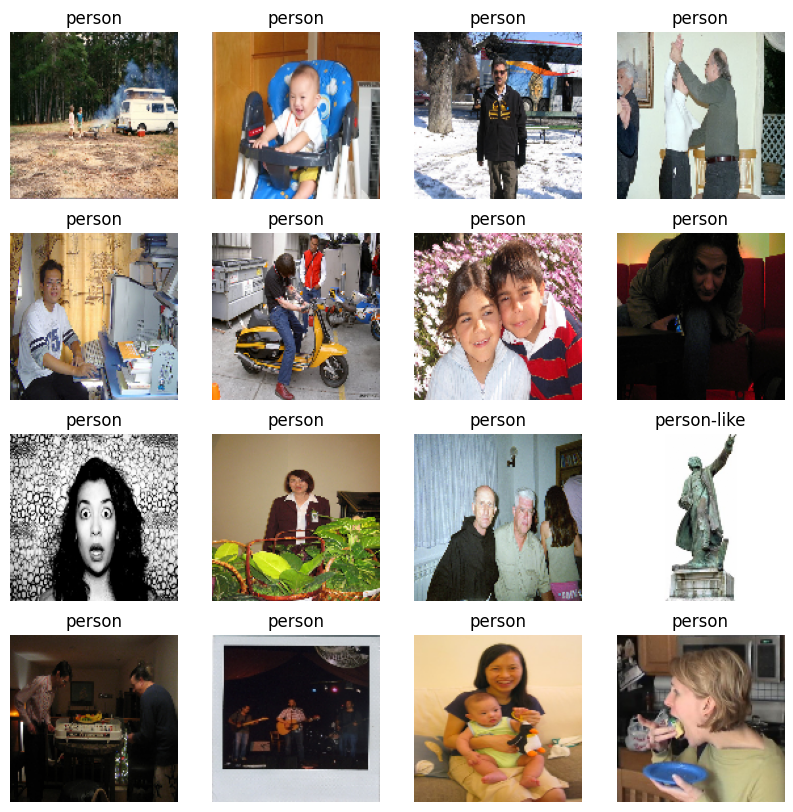

In [65]:
# Display 16 random images from training dataset
plt.figure(figsize=(10,10))
for n , i in enumerate(list(np.random.randint(0,len(train_images),16))) :
    plt.subplot(4,4,n+1)
    # Show and adjust channels
    plt.imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
    plt.title(class_names[train_labels[i]])
    plt.axis('off')

In [15]:
def img_to_input(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to gray scale
    return gray_img.flatten() # Turn 2D array into 1D array

In [16]:
# Convert to valid input for fully connected neural network
train_input = np.array([img_to_input(image) for image in train_images])
val_input = np.array([img_to_input(image) for image in val_images])
test_input = np.array([img_to_input(image) for image in test_images])

In [83]:
model = Sequential() # Initialize a sequential model
model.add(Input(shape=(pixel_count,))) # Add an input layer
model.add(Dense(units = 200, activation = 'relu')) # First hidden layer
model.add(Dropout(0.1)) # Dropout to attempt to mitigate overfit
model.add(Dense(units = 100, activation = 'relu')) # Second (smaller) hidden layer
model.add(Dropout(0.1))
model.add(Dense(units = 100, activation = 'relu')) # Third hidden layer
model.add(Dense(units = 1, activation = 'sigmoid')) # output neuron

# Compile using small learning rate and binary cross entropy
model.compile(optimizer = Adam(learning_rate = 0.005), loss="binary_crossentropy", metrics=["accuracy"])

In [85]:
# Train the model using a medium batch size and epoch count
# (larger amount of epochs don't improve the result in this scenario)
hist = model.fit(x=train_input, y=train_labels, validation_data=(val_input, val_labels), verbose=2, batch_size = 50, epochs = 100, shuffle="true")

Epoch 1/100
19/19 - 0s - 10ms/step - accuracy: 0.9025 - loss: 0.2261 - val_accuracy: 0.5625 - val_loss: 1.1240
Epoch 2/100
19/19 - 0s - 8ms/step - accuracy: 0.9057 - loss: 0.2162 - val_accuracy: 0.6250 - val_loss: 0.9539
Epoch 3/100
19/19 - 0s - 8ms/step - accuracy: 0.9386 - loss: 0.1574 - val_accuracy: 0.5938 - val_loss: 1.0820
Epoch 4/100
19/19 - 0s - 8ms/step - accuracy: 0.9269 - loss: 0.1593 - val_accuracy: 0.5938 - val_loss: 1.1043
Epoch 5/100
19/19 - 0s - 9ms/step - accuracy: 0.9396 - loss: 0.1424 - val_accuracy: 0.5813 - val_loss: 1.1336
Epoch 6/100
19/19 - 0s - 8ms/step - accuracy: 0.9386 - loss: 0.1437 - val_accuracy: 0.6187 - val_loss: 1.0946
Epoch 7/100
19/19 - 0s - 8ms/step - accuracy: 0.9449 - loss: 0.1284 - val_accuracy: 0.5875 - val_loss: 1.2134
Epoch 8/100
19/19 - 0s - 8ms/step - accuracy: 0.9354 - loss: 0.1554 - val_accuracy: 0.5750 - val_loss: 1.3763
Epoch 9/100
19/19 - 0s - 8ms/step - accuracy: 0.9131 - loss: 0.1972 - val_accuracy: 0.5875 - val_loss: 1.2311
Epoch 10/

In [86]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

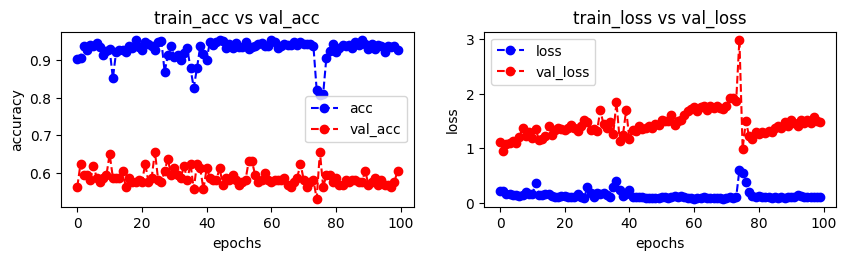

In [87]:
plot_accuracy_loss(hist)